In [3]:
# モジュールのインポート
from matplotlib import pyplot
from matplotlib import patches
import random
import numpy as np
import array
import math
import scipy.stats

from itertools import repeat
from collections.abc import Sequence
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
%matplotlib inline

In [4]:
# roomというclassを作る
class Room():
    def __init__(self,n,s,m,w=0,l=0,x=0,ud=0):
        self.n = n # number
        self.s = s # area
        self.m = m # move_frequency
        self.w = w # width
        self.l = l # length
        self.x = x # exitpoint 
        self.ud = ud # up and down
    # aとbとの距離
    def distance(self,b):
        return (abs( self.x - b.x )+ abs( self.ud - b.ud )) * self.m[b.n]
    # 壁と床の建設コスト
    def construction_cost(self):
        S = self.w * self.l
        wall = (self.w + self.l)*2
        return S * 1 + wall * 1
    # 想定する面積との差異
    def area_diffrence(self):
        return abs(self.w * self.l - self.s)
    def display(self):
        return [self.n,self.s,self.m,self.w,self.l,self.x,self.ud]

In [23]:
# 遺伝子を生成
def room_gene():
    spd = np.array([random.randint(0,10),random.randint(0,10),random.randint(0,8)]) # スタート地点と上下に分かれる番号
    seq = np.array([random.sample(range(0,8),8)]).T # 順番
    wl = np.array([[random.randint(1,10) for i in range(16)]]).reshape(2,8).T # 縦と横の長さ
    gene = np.hstack((seq, wl)).flatten()
    gene = np.insert(gene, 0, spd)
    return gene

# 遺伝子を用途ごとに分解
def disassembly(individual):
    start_point = individual[0:2]
    divine = individual[2]
    ind = np.delete(individual, [0,1,2]).reshape(8,3)
    seq = ind[:,0].flatten()
    return start_point, divine, ind, seq

def quota(Rooms,individual):
    start_point, divine, ind, seq = disassembly(individual)
    for room in Rooms:
        n = room.n
        room.w = ind[n][1]
        room.l = ind[n][2]
    rearrang_rooms = [Rooms[i-1] for i in seq]
    u,d = [],[]
    c = 0
    for rearrang_room in rearrang_rooms:
        c = c + 1
        if c <= divine:
            rearrang_room.ud = 0
            rearrang_room.x = start_point[0] + sum(u) + rearrang_room.w/2
            u.append(rearrang_room.w)
        else:
            rearrang_room.ud = 1
            rearrang_room.x = start_point[1] + sum(d) + rearrang_room.w/2
            d.append(rearrang_room.w)
    return Rooms

In [6]:
# 評価関数
def Eval(individual):
    start_point, divine, ind, seq = disassembly(individual)
    global Rooms
    Rooms = quota(Rooms,individual)
    
    distance = []
    construction_cost = []
    area_diffrence = []
    
    for room in Rooms:
        distance.append(sum([room.distance(i) for i in Rooms]))
        construction_cost.append(room.construction_cost()**2)
        area_diffrence.append(room.area_diffrence()**2)
    s_dis = sum(distance)
    s_con = sum(construction_cost)
    s_are = sum(area_diffrence)
    return s_dis,s_con,s_are

In [7]:
# 交叉
def CX(ind1, ind2):
    
    start_point1, divine1, ind1, seq1 = disassembly(ind1)
    start_point2, divine2, ind2, seq2 = disassembly(ind2)
    
    if random.random() < 0.5:
        ## cxTwoPoint
        size = min(len(ind1), len(ind2))
        cxpoint1 = random.randint(1, size)
        cxpoint2 = random.randint(1, size - 1)
        if cxpoint2 >= cxpoint1:
            cxpoint2 += 1
        else:  # Swap the two cx points
            cxpoint1, cxpoint2 = cxpoint2, cxpoint1

        ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] \
            = ind2[cxpoint1:cxpoint2], ind1[cxpoint1:cxpoint2]
    else:
        a = random.random()
        if a < 0.25:
            start_point1[0],start_point2[1] = start_point2[0],start_point1[1]
        elif 0.25 <= a and a < 0.5:
            start_point1[1],start_point2[0] = start_point2[1],start_point1[0]
        elif 0.5 <= a and a < 0.75:
            start_point1[0],start_point2[0] = start_point2[0],start_point1[0]
        else:
            if random.random() < 0.5:
                divine1 = divine2
            else:
                divine2 = divine1

    ind1 = ind1.flatten()
    ind1 = np.append(np.append(start_point1,divine1),ind1)
    ind2 = ind2.flatten()
    ind2 = np.append(np.append(start_point2,divine2),ind2)
    return ind1, ind2

In [8]:
# 突然変異
def MUT(individual):
    start_point, divine, ind, seq = disassembly(individual)
    size = len(ind)
    if random.random() < 0.5:
        # mutswapIndexes
        swpoint1 = random.randint(0, size - 1)
        swpoint2 = random.randint(0, size - 2)
        if swpoint2 >= swpoint1:
            swpoint2 += 1
        else:
            swpoint1, swpoint2 = swpoint2, swpoint1
        ind = np.insert(ind, swpoint1, ind[swpoint2], axis=0)
        ind = np.delete(ind,swpoint1+1,axis=0)
        ind = np.insert(ind, swpoint2, ind[swpoint1], axis=0)
        ind = np.delete(ind,swpoint2+1,axis=0)
    else:
        # mutchangeIndexes
        cgpoint = random.randint(0,size - 1)
        ind_ = np.hstack((ind[cgpoint][0],[random.randint(1,10)],[random.randint(1,10)] ))
        ind = np.insert(ind, cgpoint, ind_, axis=0)
        ind = np.delete(ind,cgpoint+1,axis=0)
        
    if random.random() < 0.5:
        start_point = [random.randint(0,10),random.randint(0,10)]
    else:
        divine = random.randint(0,10)
    
    ind = ind.flatten()
    individual = np.append(np.append(start_point,divine),ind)
    return individual,

In [9]:
# 定義
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# 初期条件を構築
toolbox.register("individual", tools.initIterate, creator.Individual, room_gene)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 評価関数、交差、突然変異、選択淘汰
toolbox.register("evaluate", Eval)
toolbox.register("mate", CX)
toolbox.register("mutate", MUT)
toolbox.register("select", tools.selTournament, tournsize=100)

In [10]:
def conf(best_ind):
    start_point, divine, ind, seq = disassembly(best_ind)
    global Rooms
    Rooms = quota(Rooms,best_ind)

    fig, ax = pyplot.subplots()

    ax.set_xlim([0,41])
    ax.set_ylim([-11,11])
    ax.grid()
    ax.add_patch(patches.Rectangle( xy=(0,-10.5) ,facecolor="white",edgecolor="black", width=40, height=21))

    for room in Rooms:
        if room.ud == 0:
            ud = 1
        else:
            ud = -1*room.l
        r = patches.Rectangle( xy=(room.x-room.w/2,ud) ,facecolor="white",edgecolor="red", width=room.w, height=room.l) 
        ax.add_patch(r)
    ax.add_patch(patches.Rectangle( xy=(0,0) ,facecolor="white",edgecolor="black", width=40, height=1))

    pyplot.axis('off')
    pyplot.show()

In [24]:
def main(n,CXPB, MUTPB ,NGEN):
    pop = toolbox.population(n=n)
    CXPB, MUTPB ,NGEN = CXPB, MUTPB ,NGEN
    print("Start of evolution")

    fitnesses = list(map(toolbox.evaluate, pop))
    
    fit1,fit2,fit3,normal_fitnesses = [],[],[],[]
    for i in range(n):
        fit1.append(fitnesses[i][0])
        fit2.append(fitnesses[i][1])
        fit3.append(fitnesses[i][2])
    fit1 = scipy.stats.zscore(fit1)
    fit2 = scipy.stats.zscore(fit2)
    fit3 = scipy.stats.zscore(fit3)

    for i in range(n):
        normal_fitnesses.append(((fit1 + fit2 + fit3)[i],))
    for ind, fit in zip(pop, normal_fitnesses):
        ind.fitness.values = fit
    
    fits = [ind.fitness.values[0] for ind in pop]
    
    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
    log = [[min(fits),max(fits),mean,std]]
    
    print("  Evaluated %i individuals" % len(pop))
    print("gen　　　nevals　　　avg　　　std　　　min　　　max" )
    g = 0
    while  g < NGEN :
        g = g + 1
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        
        fit1,fit2,fit3,normal_fitnesses = [],[],[],[]
        for i in range(len(invalid_ind)):
            fit1.append(fitnesses[i][0])
            fit2.append(fitnesses[i][1])
            fit3.append(fitnesses[i][2])
        fit1 = scipy.stats.zscore(fit1)
        fit2 = scipy.stats.zscore(fit2)
        fit3 = scipy.stats.zscore(fit3)
        for i in range(len(invalid_ind)):
            normal_fitnesses.append(((fit1 + fit2 + fit3)[i],))
        for ind, fit in zip(invalid_ind, normal_fitnesses):
            ind.fitness.values = fit
        
        pop[:] = offspring

        fits = [ind.fitness.values[0] for ind in pop]
        fits = [0 if e == "NaN" or math.isnan(e) else e for e in fits]
        # 母集団の最小、最大、平均、標準偏差を表示
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
        log.append([min(fits),max(fits),mean,std])
        
        print('%2d　　　%4d　　　%5d　　%5d　　%5d　　%5d' % (g,len(invalid_ind),mean,std,min(fits),max(fits)))
    print("-- End of (successful) evolution --")
    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    return best_ind, log

Start of evolution
  Evaluated 1000 individuals
gen　　　nevals　　　avg　　　std　　　min　　　max
 1　　　 906　　　    0　　    2　　   -5　　    6
 2　　　 898　　　    0　　    2　　   -5　　    7
 3　　　 901　　　    0　　    1　　   -5　　   14
 4　　　 914　　　    0　　    1　　   -5　　    0
 5　　　 882　　　    0　　    0　　   -5　　    0
 6　　　 897　　　    0　　    0　　   -5　　    0
 7　　　 902　　　    0　　    0　　    0　　    0
 8　　　 886　　　    0　　    0　　    0　　    0
 9　　　 912　　　    0　　    0　　    0　　    0
10　　　 901　　　    0　　    0　　    0　　    0
11　　　 908　　　    0　　    0　　    0　　    0
12　　　 898　　　    0　　    0　　    0　　    0
13　　　 908　　　    0　　    0　　    0　　    0
14　　　 896　　　    0　　    0　　    0　　    0
15　　　 904　　　    0　　    0　　    0　　    0
16　　　 891　　　    0　　    0　　    0　　    0
17　　　 882　　　    0　　    0　　    0　　    0
18　　　 889　　　    0　　    0　　    0　　    0
19　　　 908　　　    0　　    0　　    0　　    0
20　　　 906　　　    0　　    0　　    0　　    0
21　　　 905　　　    0　　    0　　    0　　    0
22　　　 899　　　    0　　    0　　    0　　    0
23　　　 909　　　    0　　    0　　    0　　    0
24　　　 889　　　    0　

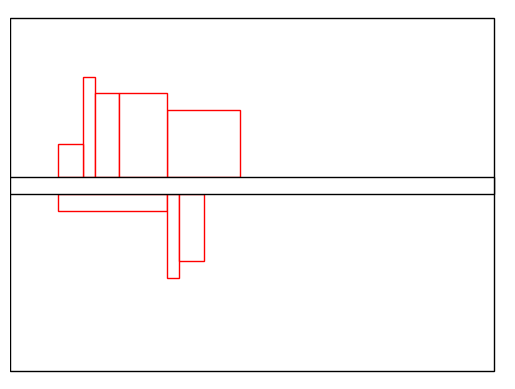

In [26]:
# 設定（部屋番号,部屋の面積,部屋と部屋の間の移動コスト）
Room_1 = Room(0,15,[0,1,1,1,1,1,1,1])
Room_2 = Room(1,15,[1,0,1,1,1,1,1,1])
Room_3 = Room(2,15,[1,1,0,1,1,1,1,1])
Room_4 = Room(3,15,[1,1,1,0,1,1,1,1])
Room_5 = Room(4,15,[1,1,1,1,0,1,1,1])
Room_6 = Room(5,15,[1,1,1,1,1,0,1,1])
Room_7 = Room(6,15,[1,1,1,1,1,1,0,1])
Room_8 = Room(7,15,[1,1,1,1,1,1,1,0])
Rooms = [Room_1,Room_2,Room_3,Room_4,Room_5,Room_6,Room_7,Room_8]

# 実行
n = 1000
CXPB, MUTPB ,NGEN = 0.5, 0.8, 30
if __name__ == "__main__":
    best_ind, log = main(n,CXPB, MUTPB ,NGEN)
conf(best_ind)

[[1 1 5]
 [7 7 4]
 [2 2 4]
 [3 3 4]
 [4 4 4]
 [5 5 4]
 [6 6 4]
 [0 9 5]]


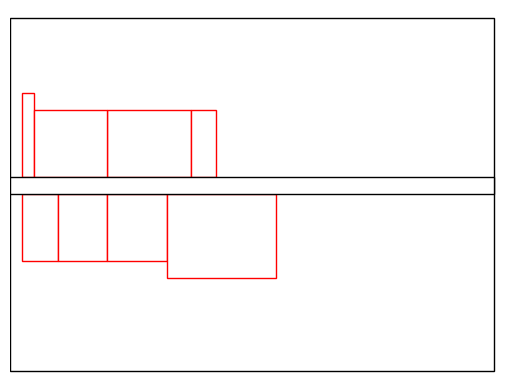

In [27]:
Best = [1, 1, 4, 1, 1, 5, 7, 7, 4, 2, 2, 4, 3, 3, 4, 4, 4, 4, 5, 5, 4, 6, 6, 4, 0, 9, 5]

start_point, divine, ind, seq = disassembly(Best)
print(ind)

conf(Best)